<a href="https://colab.research.google.com/github/viferraro/DeepLearning/blob/main/CIFAR10AlexNetTestes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyJoules[nvidia]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 825.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.9 MB/s eta 0:00:00


In [2]:
!pip install keras_flops

In [9]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.python.client import device_lib
from pyJoules.energy_meter import measure_energy
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from datetime import datetime
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt


In [6]:
# Carregando os dados
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Dividindo o conjunto de treinamento em treinamento e validação
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

# Pré-processando os dados
x_train = x_train.reshape(-1, 32, 32, 3).astype('float32')
x_test = x_test.reshape(-1, 32, 32, 3).astype('float32')
x_valid = x_valid.reshape(-1, 32, 32, 3).astype('float32')

x_train /= 255
x_test /= 255
x_valid /= 255

n_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, n_classes)
y_test = tf.keras.utils.to_categorical(y_test, n_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, n_classes)

170498071/170498071 [==============================] - 6s 0us/step


In [7]:
model = Sequential()
model.add(Conv2D(32, input_shape=(32, 32, 3), kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 28, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 64)        3

In [10]:
models = []
val_accuracies = []
accuracies = []

for i in range(10):
  print('-------------------------------------------------------------')
  print('modelo ' + str(i+1))
  tempo1 = datetime.now()

  @measure_energy
  def foo():
   return model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1, validation_data=(x_valid, y_valid))

  history = foo()

  tempo2 = datetime.now()

  print(f"O tempo de treino em (hh:mm:ss.ms) foi {tempo2-tempo1}")

  media_acc =  np.mean(history.history['accuracy'])
  media_acc_val = np.mean(history.history['val_accuracy'])
  val_accuracies.append(media_acc_val)
  accuracies.append(media_acc_val)
  print(f'Média das acurácias: {media_acc}')
  print(f'Média das acurácias(val): {media_acc_val}')

  # Função para calcular FLOPs
  def get_flops(model):
      # Convert the model to a constant graph
      full_model = tf.function(lambda x: model(x))
      full_model = full_model.get_concrete_function(
          tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
      frozen_func = convert_variables_to_constants_v2(full_model)
      frozen_func.graph.as_graph_def()

      # Calculate the FLOPs
      run_meta = tf.compat.v1.RunMetadata()
      opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
      flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,
                                            run_meta=run_meta, cmd='op', options=opts)
      return flops.total_float_ops

  flops = get_flops(model)
  print(f"FLOPS: {flops / 10 ** 9:.03} G")

# Evaluate the model
  val_loss, val_accuracy = model.evaluate(x_valid, y_valid, verbose=0)

 # Store the model and its accuracy
  models.append(model)
  val_accuracies.append(media_acc_val)

mean_accuracy_val = np.mean(val_accuracies)
print(f'Média da Acurácia geral: {mean_accuracy_val}')

# Select the model with the highest accuracy
best_model_index = accuracies.index(max(accuracies))
best_model = models[best_model_index]
print('***********************************')
print('O modelo escolhido para inferência foi o modelo: ' + str(best_model_index+1))

# Use the best model for inference
tempo3 = datetime.now()
y_pred = best_model.predict(x_test)
tempo4 = datetime.now()
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

acuracia = accuracy_score(y_test_classes, y_pred_classes)
precisao = precision_score(y_test_classes, y_pred_classes, average='macro')
recal = recall_score(y_test_classes, y_pred_classes, average='macro')
f1 = f1_score(y_test_classes, y_pred_classes, average='macro')

print(f'Acurácia: {acuracia}')
print(f'Precisão: {precisao}')
print(f'Recall: {recal}')
print(f'F1-Score: {f1}')

print(f"O tempo de inferência em (hh:mm:ss.ms) foi {tempo4-tempo3}")

-------------------------------------------------------------
modelo 1
Epoch 1/20
313/313 [==============================] - 14s 21ms/step - loss: 1.6087 - accuracy: 0.4137 - val_loss: 1.3477 - val_accuracy: 0.5221
Epoch 2/20
313/313 [==============================] - 5s 17ms/step - loss: 1.2798 - accuracy: 0.5451 - val_loss: 1.2743 - val_accuracy: 0.5508
Epoch 3/20
313/313 [==============================] - 5s 17ms/step - loss: 1.1381 - accuracy: 0.5957 - val_loss: 1.1786 - val_accuracy: 0.5742
Epoch 4/20
313/313 [==============================] - 6s 18ms/step - loss: 1.0546 - accuracy: 0.6281 - val_loss: 1.1323 - val_accuracy: 0.6059
Epoch 5/20
313/313 [==============================] - 5s 16ms/step - loss: 0.9730 - accuracy: 0.6564 - val_loss: 1.0323 - val_accuracy: 0.6362
Epoch 6/20
313/313 [==============================] - 5s 17ms/step - loss: 0.9338 - accuracy: 0.6712 - val_loss: 1.0112 - val_accuracy: 0.6448
Epoch 7/20
313/313 [==============================] - 5s 16ms/step - l

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


FLOPS: 0.0 G
-------------------------------------------------------------
modelo 2
Epoch 1/20
313/313 [==============================] - 6s 18ms/step - loss: 0.4882 - accuracy: 0.8294 - val_loss: 1.1174 - val_accuracy: 0.6779
Epoch 2/20
313/313 [==============================] - 5s 17ms/step - loss: 0.4988 - accuracy: 0.8246 - val_loss: 1.0948 - val_accuracy: 0.6803
Epoch 3/20
313/313 [==============================] - 5s 16ms/step - loss: 0.4571 - accuracy: 0.8404 - val_loss: 1.1855 - val_accuracy: 0.6650
Epoch 4/20
313/313 [==============================] - 5s 16ms/step - loss: 0.4368 - accuracy: 0.8468 - val_loss: 1.1838 - val_accuracy: 0.6772
Epoch 5/20
313/313 [==============================] - 5s 17ms/step - loss: 0.4090 - accuracy: 0.8562 - val_loss: 1.2011 - val_accuracy: 0.6730
Epoch 6/20
313/313 [==============================] - 5s 16ms/step - loss: 0.3812 - accuracy: 0.8658 - val_loss: 1.2353 - val_accuracy: 0.6686
Epoch 7/20
313/313 [==============================] - 5s 1

In [11]:
cm = confusion_matrix(y_test_classes, y_pred_classes)

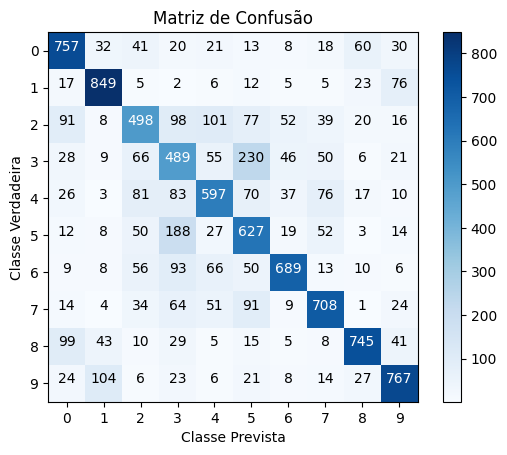

In [12]:
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))

fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.show()